In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install tensorflow_addons

In [41]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [42]:
# Calculate class_weights for 5 class

def get_class_weights(dataset, class_count=5):
    labels = []
    for _, label in dataset:
        labels.append(np.argmax(label.numpy(), 1)) # argmax needed if labels are in onehot enc.

    labels = np.hstack(labels) # list of np arrays stacking horizontally as a single np list
    samples_per_class = Counter(labels)  # Class index number mapping to number of samples in that class
    total_sample_count = len(labels) # total number of samples in this dataset


    class0_weight = (total_sample_count/ (class_count*samples_per_class[0]) )
    class1_weight = (total_sample_count/ (class_count*samples_per_class[1]) )
    class2_weight = (total_sample_count/ (class_count*samples_per_class[2]) )
    class3_weight = (total_sample_count/ (class_count*samples_per_class[3]) )
    class4_weight = (total_sample_count/ (class_count*samples_per_class[4]) )

    class_weights = {0: class0_weight, 1: class1_weight, 2: class2_weight, 3: class3_weight, 4: class4_weight}
    return class_weights

In [43]:

# Define dataset paths
train_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/train'
val_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/val'
test_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/test'


# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
SEED = 42

# Create datasets using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=True,  # to introduce randomness in each epoch and improve training.
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)


class_index_to_label = {i: label for i, label in enumerate(train_ds.class_names)}
print('Class index number mapping to class folder names: ',class_index_to_label)
class_weights_train = get_class_weights(train_ds)
print('Class weights (train dataset): ', class_weights_train)

# Apply preprocessing
def preprocess_image(image, label):
#     image = tfa.image.gaussian_filter2d(image, (3, 3), 1.0)
    image = tfa.image.equalize(image)
    return image, label


train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=200)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)


# Optimize data loading (optional)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
Class index number mapping to class folder names:  {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
Class weights (train dataset):  {0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [44]:
base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [45]:
def weighted_ce(weights):
    weights = tf.keras.backend.variable(weights)

    def loss(y_true, y_pred):
        # Scale predictions so that the class probabilities of each sample sum to 1
        y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)
        # Clip predictions to prevent NaNs and Inf values
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Calculate the weighted categorical cross-entropy loss
        loss = y_true * tf.keras.backend.log(y_pred) * weights
        loss = -tf.keras.backend.sum(loss, -1)
        return loss
    return loss




def weighted_focal_loss(gamma=2.0, alpha=1.0, weights=None):
    def focal_loss(y_true, y_pred):
        # Clip predictions to avoid NaN loss values.
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate cross-entropy term.
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate focal term.
        focal_term = alpha * K.pow(1 - y_pred, gamma)

        # Weight focal term if custom weights are provided.
        if weights is not None:
            focal_term = focal_term * weights

        # Combine cross-entropy and focal terms.
        loss = cross_entropy * focal_term

        return K.mean(loss, axis=-1)
    return focal_loss



In [33]:
# trained_model = tf.keras.models.load_model('/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_without_classweights.h5')

In [46]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]

class_weights_list = list(class_weights_train.values())

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_with_classweights.h5', monitor='val_accuracy', mode='max', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_with_classweights_logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),  # Stop training if no improvement after 7 epochs
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),  # Reduce learning rate if no improvement after 2 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0),
]


model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=weighted_ce(class_weights_list),
        metrics=['accuracy']
)


history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[my_callbacks],
)


Epoch 1/25
289/289 [==============================] - ETA: 0s - loss: 22.3437 - accuracy: 0.2040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 203s 466ms/step - loss: 22.3437 - accuracy: 0.2040 - val_loss: 21.8791 - val_accuracy: 0.3002
Epoch 2/25
289/289 [==============================] - 95s 313ms/step - loss: 21.5209 - accuracy: 0.2908 - val_loss: 21.2417 - val_accuracy: 0.2191
Epoch 3/25
289/289 [==============================] - 107s 354ms/step - loss: 20.7568 - accuracy: 0.3969 - val_loss: 20.2366 - val_accuracy: 0.5387
Epoch 4/25
289/289 [==============================] - 98s 313ms/step - loss: 20.0047 - accuracy: 0.4927 - val_loss: 19.8660 - val_accuracy: 0.4322
Epoch 5/25
289/289 [==============================] - 108s 357ms/step - loss: 19.3358 - accuracy: 0.5519 - val_loss: 19.0245 - val_accuracy: 0.5799
Epoch 6/25
289/289 [==============================] - 95s 314ms/step - loss: 18.6340 - accuracy: 0.5933 - val_loss: 18.6972 - val_accuracy: 0.5617
Epoch 7/25
289/289 [==============================] - 108s 357ms/step - loss: 18.0106 - accuracy: 0.6282 - val_loss: 17.8068 -

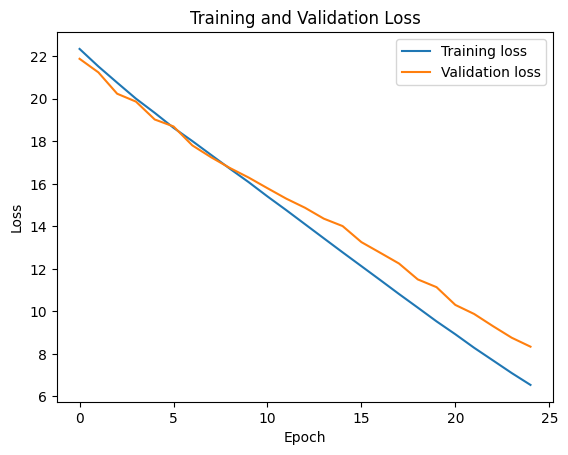

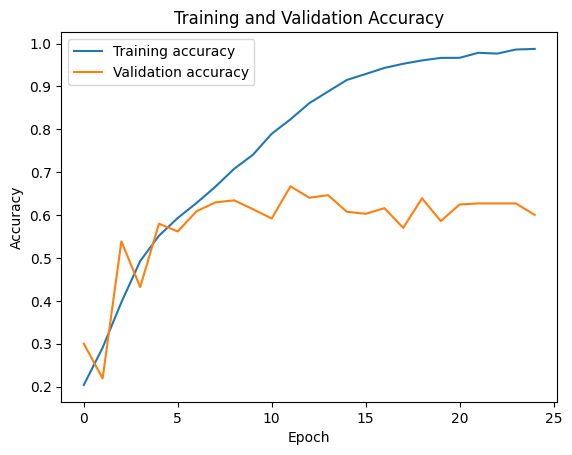

In [47]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


42/42 [==============================] - 8s 104ms/step


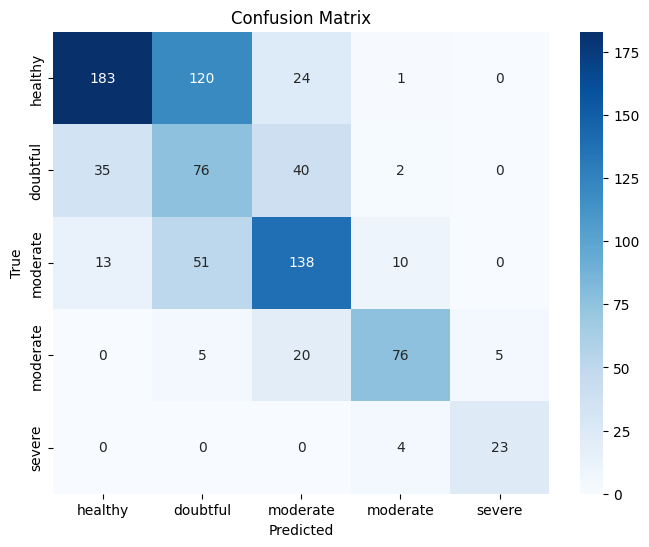

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in val_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['healthy', 'doubtful', 'moderate', 'moderate', 'severe']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true.argmax(1), y_pred.argmax(1), target_names=class_names))

              precision    recall  f1-score   support

     healthy       0.79      0.56      0.65       328
    doubtful       0.30      0.50      0.38       153
    moderate       0.62      0.65      0.64       212
    moderate       0.82      0.72      0.76       106
      severe       0.82      0.85      0.84        27

    accuracy                           0.60       826
   macro avg       0.67      0.65      0.65       826
weighted avg       0.66      0.60      0.62       826

